# Final model training

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import yaml

2024-02-24 01:31:34.601419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 01:31:34.601526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 01:31:34.685420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 01:31:34.722465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 01:31:40.285793: W tensorflow/compiler/tf2

## Load datasets

In [2]:
config_path = './config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [3]:
BP_train_df = pd.read_pickle(f"{config['directories']['preprocessed_data']}/train_embeddings_BiologicalProcesses.pkl")
CC_train_df = pd.read_pickle(f"{config['directories']['preprocessed_data']}/train_embeddings_CellularComponent.pkl")
MF_train_df = pd.read_pickle(f"{config['directories']['preprocessed_data']}/train_embeddings_MolecularFunction.pkl")
BP_label_df = pd.read_pickle(f"{config['directories']['preprocessed_data']}/train_labels_BiologicalProcesses.pkl")
CC_label_df = pd.read_pickle(f"{config['directories']['preprocessed_data']}/train_labels_CellularComponent.pkl")
MF_label_df = pd.read_pickle(f"{config['directories']['preprocessed_data']}/train_labels_MolecularFunction.pkl")
train_data_dict = {
    'Biological Processes': [BP_train_df, BP_label_df],
    'Cellular Component': [CC_train_df, CC_label_df],
    'Molecular Function': [MF_train_df, MF_label_df]
}

# Prepare training loop

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def train_model(model, dataset_name, data, BATCH_SIZE):
    train, label = data
    print('=======================================================================')
    print(f'Training for {dataset_name}')
    print(f'{model.summary()}')
    
    model_save_path = config["directories"]["final_models"]

    train_split, val_split, label_train, label_val = train_test_split(train, label, test_size=0.2)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto',
        min_delta=0.0001, cooldown=0, min_lr=0
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )

    history = model.fit(
        train_split, label_train,
        validation_data=(val_split, label_val),
        batch_size=BATCH_SIZE,
        epochs=50,
        callbacks=[lr_scheduler, early_stopping]
    )

    scores = model.evaluate(val_split, label_val, verbose=0)
    precision = scores[3]
    recall = scores[4]
    F1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f'Validation score: F1 score of {F1_score}; {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    if dataset_name == 'Biological Processes':
        current_model_save_path = f'{model_save_path}/best_BP_model'
    elif dataset_name == 'Molecular Function':
        current_model_save_path = f'{model_save_path}/best_MF_model'
    else:
        current_model_save_path = f'{model_save_path}/best_CC_model'

    tf.keras.models.save_model(model, current_model_save_path)
    print(f'Current best model for {dataset_name} has an F1 score of {F1_score}')

    plt.figure(figsize=(18, 6))
    plt.suptitle(f'Training on {dataset_name} dataset', fontsize=20)
    
    for key in history.history.keys():
        if key.startswith('precision'):
            train_precision = np.array(history.history[key])
        elif key.startswith('val_precision'):
            val_precision = np.array(history.history[key])
        elif key.startswith('recall'):
            train_recall = np.array(history.history[key])
        elif key.startswith('val_recall'):
            val_recall = np.array(history.history[key])
    train_f1 = 2 * train_precision * train_recall / (train_precision + train_recall)
    val_f1 = 2 * val_precision * val_recall / (val_precision + val_recall)
    
    x_values_loss = np.arange(1, len(history.history['loss']) + 1)
    x_values_accuracy = np.arange(1, len(history.history['binary_accuracy']) + 1)
    x_values_f1 = np.arange(1, len(train_f1) + 1)

    plt.subplot(1, 3, 1)
    plt.plot(x_values_loss, history.history['loss'], label='Training Loss')
    plt.plot(x_values_loss, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xticks(x_values_loss)
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(x_values_accuracy, history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(x_values_accuracy, history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xticks(x_values_accuracy)
    plt.xlabel('Training Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(x_values_f1, train_f1, label='Training F1 score')
    plt.plot(x_values_f1, val_f1, label='Validation F1 score')
    plt.title('Training and Validation F1 scores')
    plt.xticks(x_values_f1)
    plt.xlabel('Training Epoch')
    plt.ylabel('F1 Score')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
BATCH_SIZE = config['batch_size']
num_labels = 1500

# Load and randomize and train models

In [6]:
models_path = config['directories']['best_performing_k_fold_models']

category_model_paths = {
    'Biological Processes': f'{models_path}/best_BP_model',
    'Cellular Component': f'{models_path}/best_CC_model',
    'Molecular Function': f'{models_path}/best_MF_model'
}

2024-02-24 01:31:59.370600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:44:00.0, compute capability: 8.0


Training for Biological Processes
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 512)               524800    
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dense_35 (Dense)            (None, 1500)              769500    
                                                                 
Total params: 1823708 (6.96 MB)
Trainable params: 1821660 (6.95 MB)
Non-trainable para

2024-02-24 01:32:12.824015: I external/local_xla/xla/service/service.cc:168] XLA service 0x2bbb69b73ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-24 01:32:12.824063: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-24 01:32:12.838358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-24 01:32:12.967614: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708731133.251363    1475 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 [==============================] - 14s 12ms/step - loss: 0.1187 - binary_accuracy: 0.9654 - auc: 0.8190 - precision: 0.2826 - recall: 0.1388 - val_loss: 0.4647 - val_binary_accuracy: 0.9739 - val_auc: 0.8976 - val_precision: 0.6826 - val_recall: 0.1684 - lr: 0.0010
Epoch 2/50
130/130 [==============================] - 1s 8ms/step - loss: 0.0818 - binary_accuracy: 0.9746 - auc: 0.9131 - precision: 0.6754 - recall: 0.2113 - val_loss: 0.3157 - val_binary_accuracy: 0.9747 - val_auc: 0.9227 - val_precision: 0.6781 - val_recall: 0.2226 - lr: 0.0010
Epoch 3/50
130/130 [==============================] - 1s 8ms/step - loss: 0.0774 - binary_accuracy: 0.9752 - auc: 0.9262 - precision: 0.6826 - recall: 0.2433 - val_loss: 0.1809 - val_binary_accuracy: 0.9751 - val_auc: 0.9310 - val_precision: 0.6955 - val_recall: 0.2309 - lr: 0.0010
Epoch 4/50
130/130 [==============================] - 1s 8ms/step - loss: 0.0747 - binary_accuracy: 0.9756 - auc: 0.9331 - precision: 0.6879 - recall: 0.2654 - 

INFO:tensorflow:Assets written to: ./final_models/best_BP_model/assets


Current best model for Biological Processes has an F1 score of 0.45040280829244855


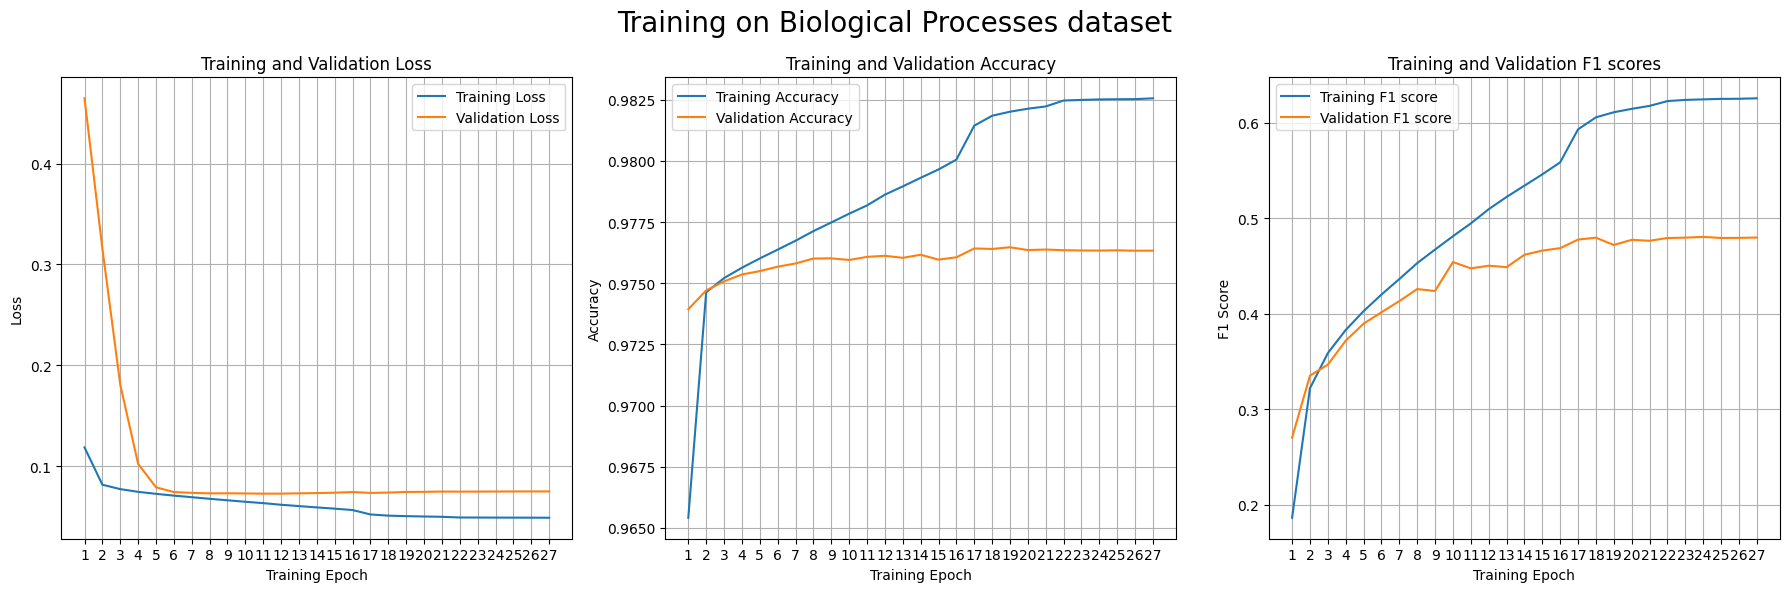

Training for Cellular Component
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_60 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_240 (Dense)           (None, 512)               524800    
                                                                 
 dense_241 (Dense)           (None, 512)               262656    
                                                                 
 dense_242 (Dense)           (None, 512)               262656    
                                                                 
 dense_243 (Dense)           (None, 1500)              769500    
                                                                 
Total params: 1823708 (6.96 MB)
Trainable params: 1821660 (6.95 MB)
Non-trainable param

INFO:tensorflow:Assets written to: ./final_models/best_CC_model/assets


Current best model for Cellular Component has an F1 score of 0.46979601303198765


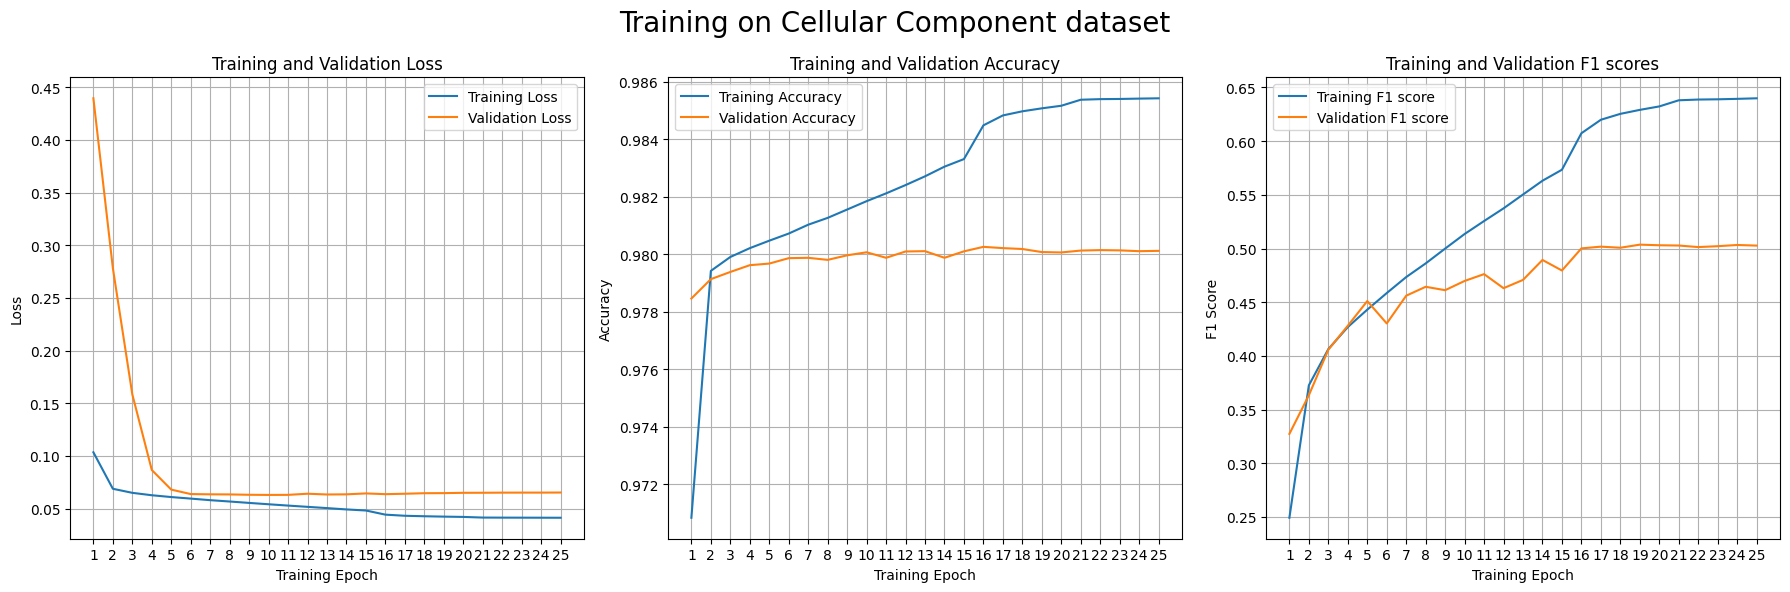

Training for Molecular Function
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_122 (B  (None, 1024)              4096      
 atchNormalization)                                              
                                                                 
 dense_488 (Dense)           (None, 512)               524800    
                                                                 
 dense_489 (Dense)           (None, 512)               262656    
                                                                 
 dense_490 (Dense)           (None, 512)               262656    
                                                                 
 dense_491 (Dense)           (None, 1500)              769500    
                                                                 
Total params: 1823708 (6.96 MB)
Trainable params: 1821660 (6.95 MB)
Non-trainable para

INFO:tensorflow:Assets written to: ./final_models/best_MF_model/assets


Current best model for Molecular Function has an F1 score of 0.5128252030392634


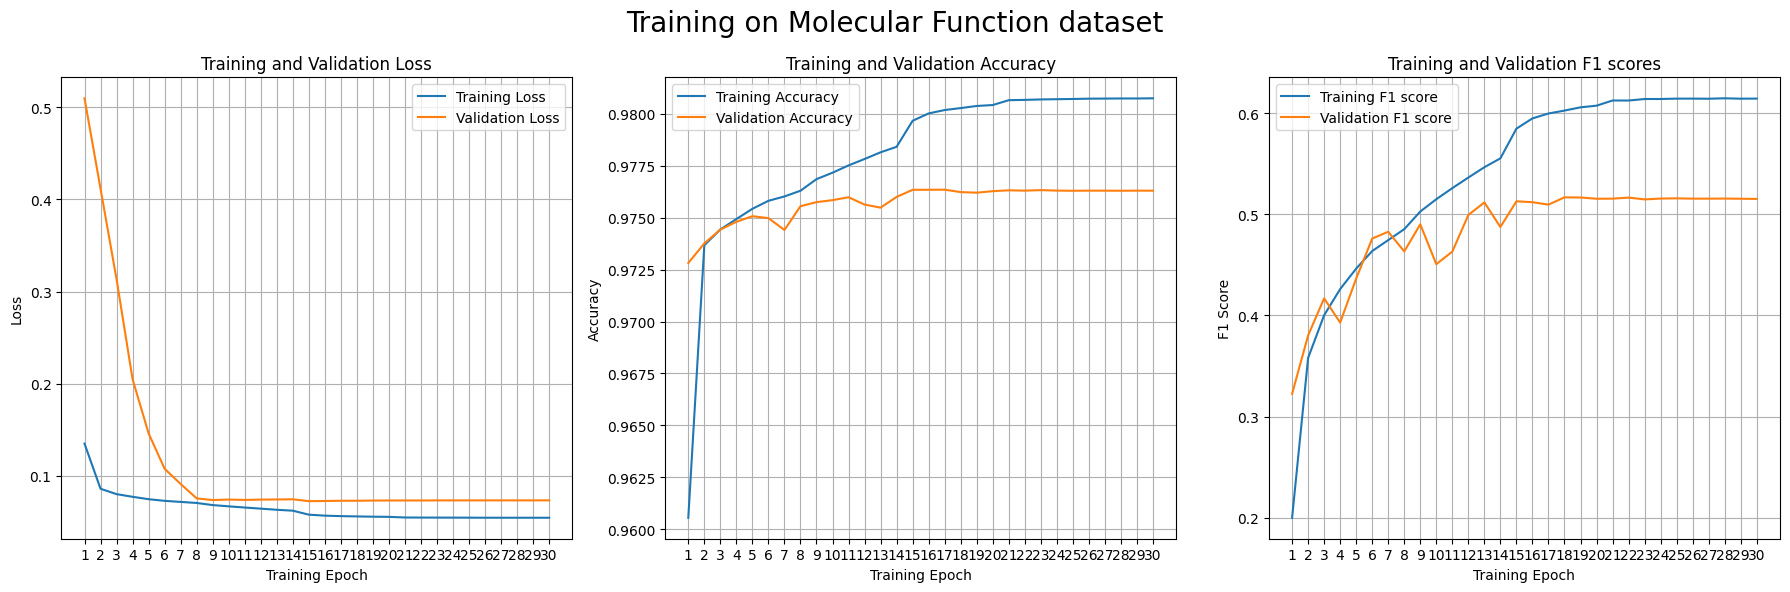

In [7]:
for dataset in train_data_dict:
    data = train_data_dict[dataset]
    model = tf.keras.models.load_model(category_model_paths[dataset])
    new_model = tf.keras.models.clone_model(model)
    
    train_model(new_model, dataset, data, BATCH_SIZE)